#### Benchmaking Experiment 004
- Model : Model4
- Dataset : PAMAP2
- Semantic Space : Glove50
- Cross Validation : 5-fold fixed classes
- Feature Loss : MSELoss

In [14]:
import os 
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from src.datasets.data import PAMAP2Reader
from src.datasets.dataset import PAMAP2Dataset
from src.datasets.utils import load_attribute

from src.models.ts_transformer import TSTransformerEncoderClassiregressor, RelativeGlobalAttention
from src.models.loss import FeatureLoss, AttributeLoss 

from src.utils.analysis import action_evaluator
# from src.running import train_step1, eval_step1

In [2]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "RelativeGlobalAttention",
    "sem-space": 'glove50-v1',
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "fold_classes": [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']],
    "lr": 0.001,
    "n_epochs": 10,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 200,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---
Model Building

In [3]:
class Model6a(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, n_classes, max_len=1024, dropout=0.1):
        super(Model6a, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        # relative global attention layer
        self.AttnL = RelativeGlobalAttention(self.d_model, self.num_heads, self.max_len)
        # positional encoding concat <-> 1DConv 
        self.Act = F.relu#_get_activation_fn(activation)
        self.AvgPoolL = nn.AvgPool2d((self.max_len,1))
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)
        self.dropout = nn.Dropout1d(dropout)
        self.logist = nn.Linear(self.ft_size, self.n_classes)

    def forward(self, x):
        out = self.DenseL(x)
        out = self.AttnL(out)
        out = self.Act(out)
        out = self.AvgPoolL(out)
        out = torch.squeeze(out)
        out = self.dropout(out)
        out1 = self.DenseL2(out)   
        out = self.logist(out1)     
        return out, out1

---

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

In [43]:
def train_step1(model, dataloader, optimizer, loss_module, device, class_names, phase='train', l2_reg=False):
    model = model.train()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, target_attr, padding_masks = batch
            # print(X, targets, target_feat, target_attr)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            target_attr = target_attr.float().to(device)
            targets = targets.long().to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output, feat_output = model(X)
                feat_loss = loss_module['feature'](class_output, targets.squeeze())

            loss = feat_loss 

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine 
            pred_class = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)
            
    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [44]:
def eval_step1(model, dataloader, loss_module, device, class_names, target_feat_met, phase='seen', l2_reg=False, print_report=True):
    model = model.train()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, target_attr, padding_masks = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            target_attr = target_attr.float().to(device)
            targets = targets.long().to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore
            # forward
            # track history if only in train
            with torch.set_grad_enabled(False):
                class_output, feat_output = model(X)
                feat_loss = loss_module['feature'](class_output, targets.squeeze())
            # define composite loss function
            loss = feat_loss

            # convert feature vector into action class
            # using cosine 
            if phase == 'seen':
                pred_action = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            else:
                feat_numpy = feat_output.cpu().detach()
                action_probs = cosine_similarity(feat_numpy, target_feat_met)
                pred_action = np.argmax(action_probs, axis=1)
                
            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action)
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})
    
    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report)
    return metrics_dict

---

In [4]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# import PAMAP2 dataset
dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [7]:
# import PAMAP2 attributes
activity_dict, attribute_dict, attr_mat = load_attribute('./data/PAMAP2_Dataset/PAMAP2_attributes.json')
_, attr_size = attr_mat.shape

In [8]:
# Load semantic feature space 
st = config['sem-space']
if st == 'glove50-v1':
    fpath = './data/PAMAP2_Dataset/glove_features.npy'
elif st == 'glove50-v2':
    fpath = './data/PAMAP2_Dataset/glove_featureV2.npy'
elif st == 'video-V1':
    fpath = './data/PAMAP2_Dataset/video_pca_ft.npy'
elif st == 'word2vec-v1':
    fpath = './data/PAMAP2_Dataset/word2vec_features.npy'
elif st == 'word2vec-v2':
    fpath = './data/PAMAP2_Dataset/word2vec_featureV2.npy'

feat_mat = np.load(fpath)
n_actions, feat_size = feat_mat.shape

In [9]:
# run 5-fold running
fold_classes = config['fold_classes']
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']


seen: 100%|██████████| 26/26 [00:00<00:00, 84.40batch/s, loss=0.752]


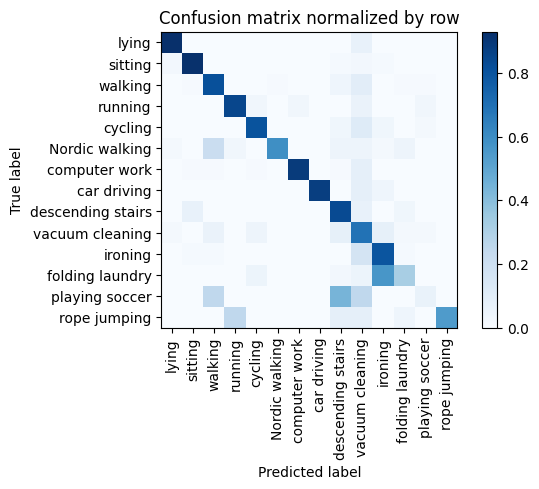

Training Epoch:  10%|█         | 1/10 [00:02<00:26,  3.00s/it]

Overall accuracy: 0.774



seen: 100%|██████████| 26/26 [00:00<00:00, 79.86batch/s, loss=0.422]


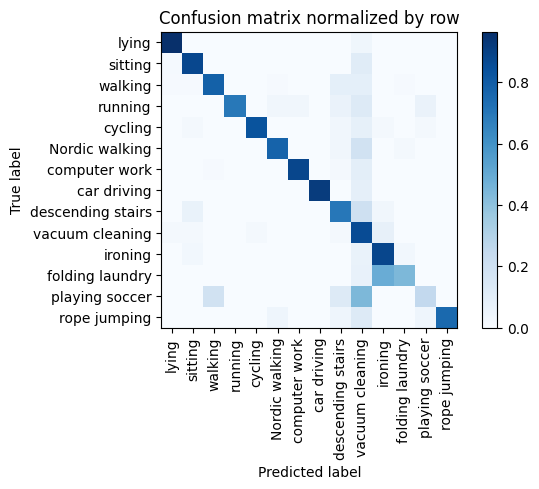

Training Epoch:  20%|██        | 2/10 [00:05<00:22,  2.81s/it]

Overall accuracy: 0.812



seen: 100%|██████████| 26/26 [00:00<00:00, 73.66batch/s, loss=0.196]


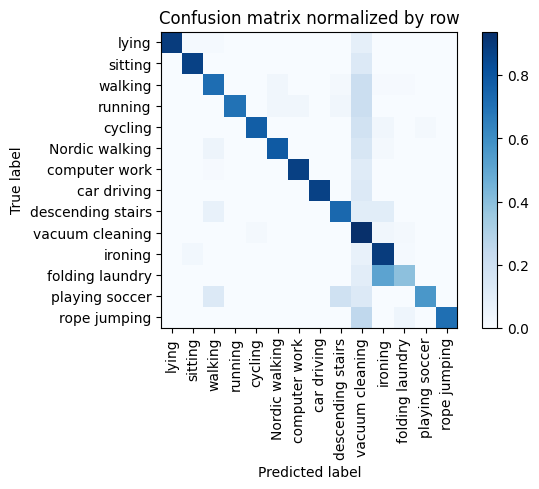

Training Epoch:  30%|███       | 3/10 [00:08<00:19,  2.76s/it]

Overall accuracy: 0.804



seen: 100%|██████████| 26/26 [00:00<00:00, 73.54batch/s, loss=0.974]


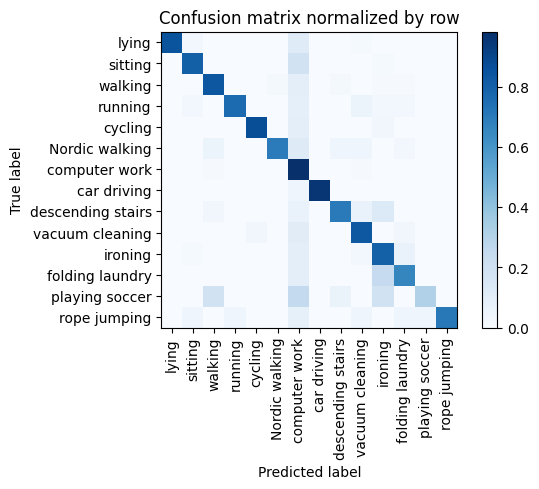

Training Epoch:  40%|████      | 4/10 [00:11<00:16,  2.72s/it]

Overall accuracy: 0.816



seen: 100%|██████████| 26/26 [00:00<00:00, 77.84batch/s, loss=0.653]


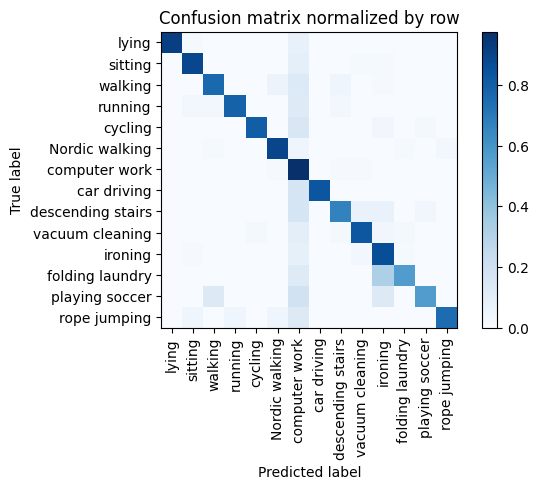

Training Epoch:  50%|█████     | 5/10 [00:13<00:13,  2.70s/it]

Overall accuracy: 0.837



seen: 100%|██████████| 26/26 [00:00<00:00, 83.86batch/s, loss=0.204]


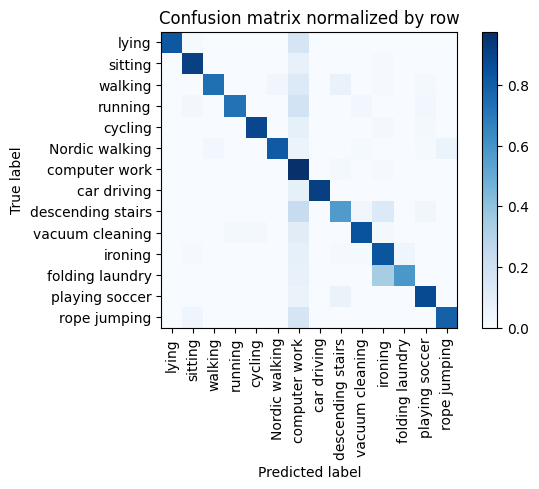

Training Epoch:  60%|██████    | 6/10 [00:16<00:10,  2.70s/it]

Overall accuracy: 0.831



seen: 100%|██████████| 26/26 [00:00<00:00, 82.14batch/s, loss=0.183]


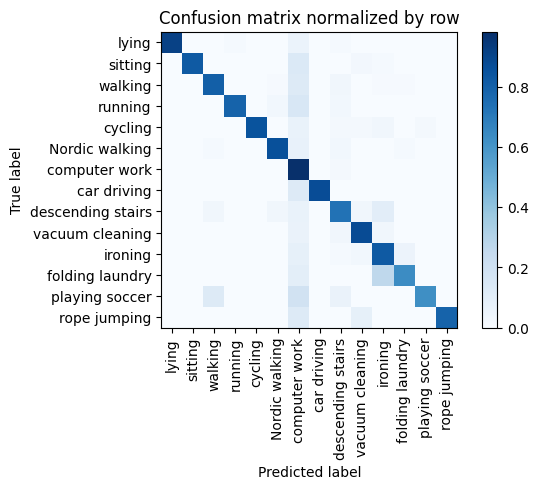

Training Epoch:  70%|███████   | 7/10 [00:19<00:08,  2.70s/it]

Overall accuracy: 0.848



seen: 100%|██████████| 26/26 [00:00<00:00, 76.45batch/s, loss=0.629]


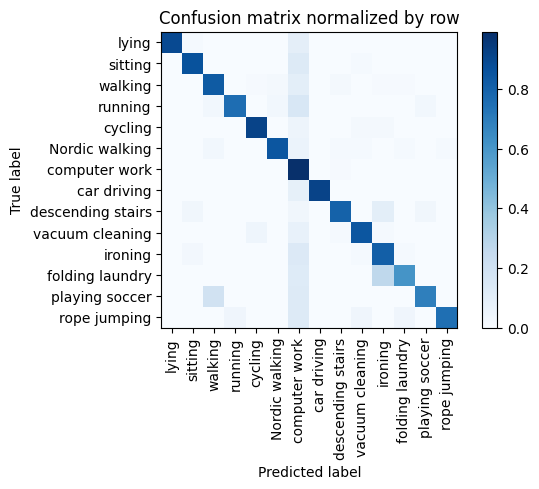

Training Epoch:  80%|████████  | 8/10 [00:21<00:05,  2.68s/it]

Overall accuracy: 0.854



seen: 100%|██████████| 26/26 [00:00<00:00, 87.51batch/s, loss=0.635]


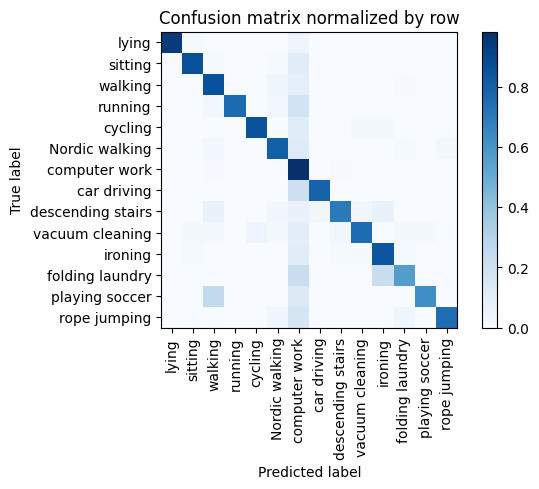

Training Epoch:  90%|█████████ | 9/10 [00:24<00:02,  2.66s/it]

Overall accuracy: 0.837



seen: 100%|██████████| 26/26 [00:00<00:00, 72.61batch/s, loss=1.48]


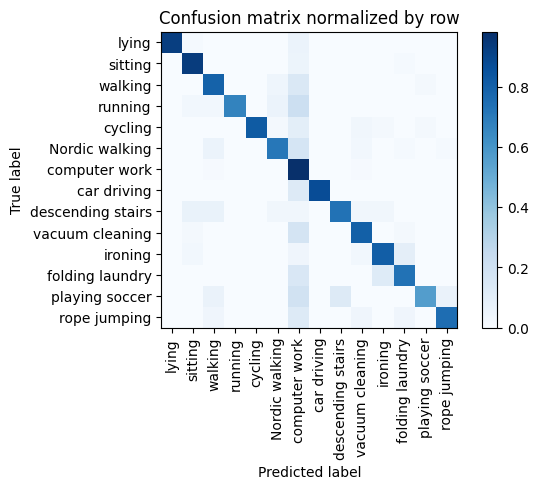

Overall accuracy: 0.834



unseen: 100%|██████████| 28/28 [00:00<00:00, 80.92batch/s, loss=7.06]


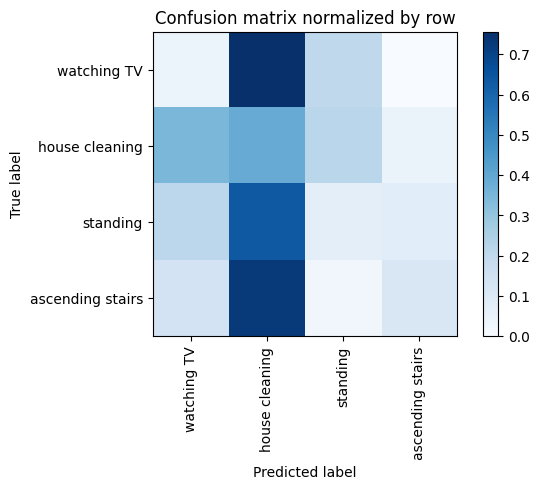

Overall accuracy: 0.177

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.186      0.071      0.103      0.337        295|	 house cleaning: 0.637,	watching TV: 0.210,	ascending stairs: 0.081,	
  house cleaning       0.213      0.386      0.274      0.325        285|	 watching TV: 0.347,	standing: 0.218,	
ascending stairs       0.333      0.112      0.168      0.193        169|	 house cleaning: 0.728,	watching TV: 0.136,	
     watching TV       0.026      0.039      0.032      0.145        127|	 house cleaning: 0.756,	standing: 0.205,	

----------------------------------------------------------------------------------------------------
     avg / total       0.200      0.177      0.161        1.0        876|	      

{'total_accuracy': 0.1769406392694064, 'precision': 0.1895987562999425, 'recall': 0.15223686680044596, 'f1': 0.14426063836875896}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope j

seen: 100%|██████████| 26/26 [00:00<00:00, 76.02batch/s, loss=1.11]


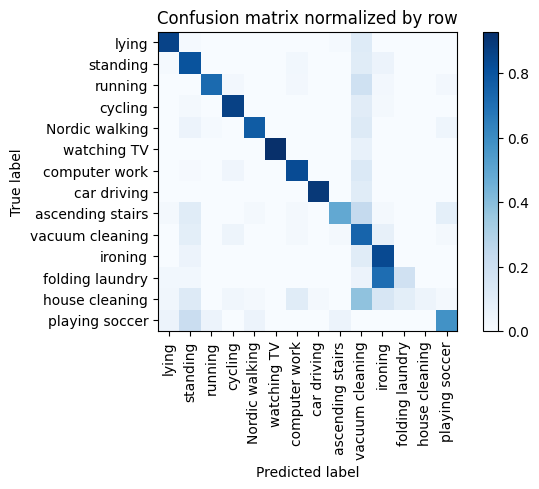

Training Epoch:  10%|█         | 1/10 [00:02<00:25,  2.85s/it]

Overall accuracy: 0.701



seen: 100%|██████████| 26/26 [00:00<00:00, 82.02batch/s, loss=1.09]


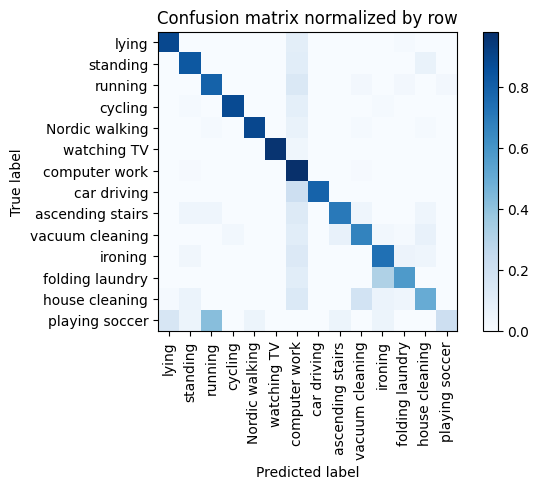

Training Epoch:  20%|██        | 2/10 [00:05<00:22,  2.77s/it]

Overall accuracy: 0.783



seen: 100%|██████████| 26/26 [00:00<00:00, 86.95batch/s, loss=0.313]


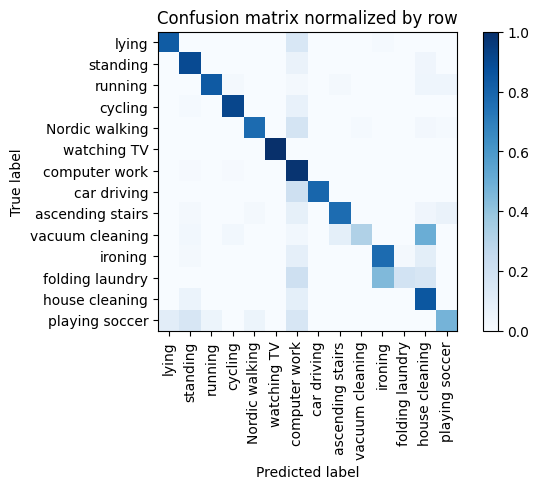

Training Epoch:  30%|███       | 3/10 [00:08<00:18,  2.70s/it]

Overall accuracy: 0.775



seen: 100%|██████████| 26/26 [00:00<00:00, 77.15batch/s, loss=0.597]


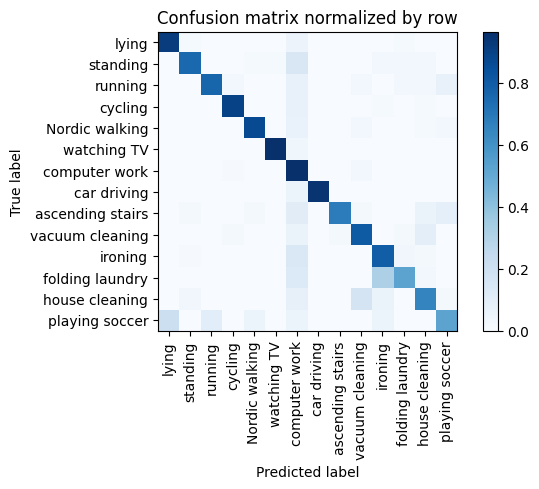

Training Epoch:  40%|████      | 4/10 [00:10<00:16,  2.67s/it]

Overall accuracy: 0.810



seen: 100%|██████████| 26/26 [00:00<00:00, 80.49batch/s, loss=1]


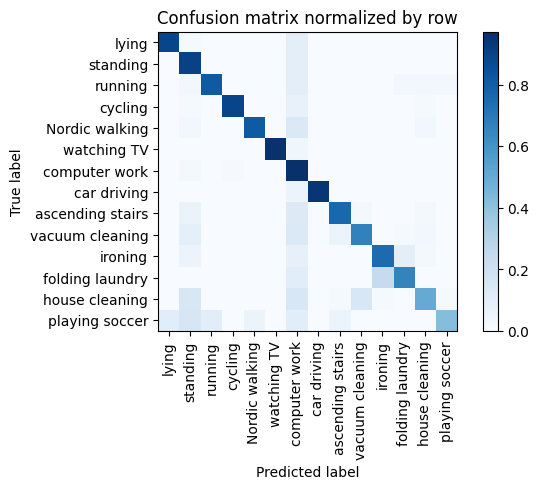

Training Epoch:  50%|█████     | 5/10 [00:13<00:13,  2.67s/it]

Overall accuracy: 0.801



seen: 100%|██████████| 26/26 [00:00<00:00, 68.14batch/s, loss=0.892]


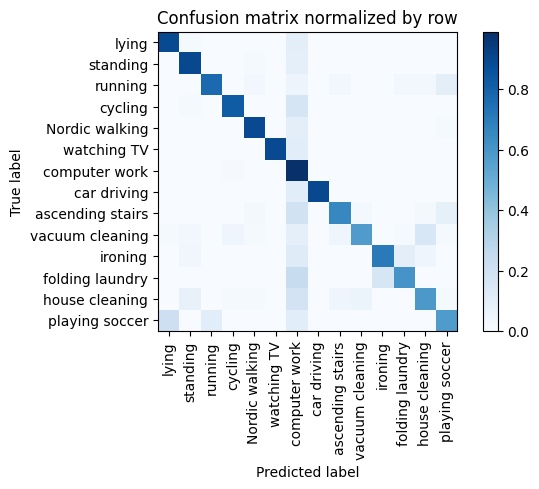

Training Epoch:  60%|██████    | 6/10 [00:16<00:10,  2.75s/it]

Overall accuracy: 0.788



seen: 100%|██████████| 26/26 [00:00<00:00, 58.43batch/s, loss=0.518]


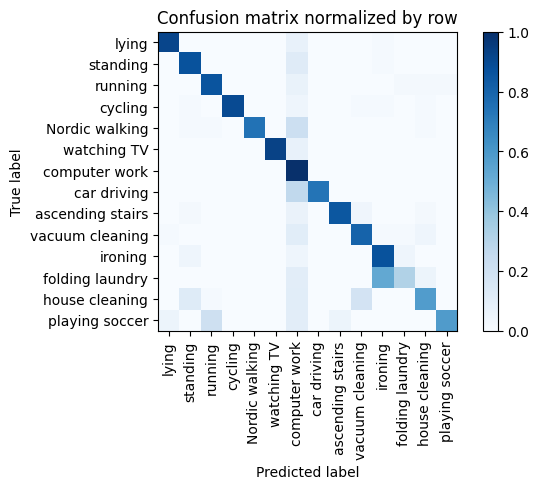

Training Epoch:  70%|███████   | 7/10 [00:19<00:08,  2.97s/it]

Overall accuracy: 0.817



seen: 100%|██████████| 26/26 [00:00<00:00, 79.76batch/s, loss=0.373]


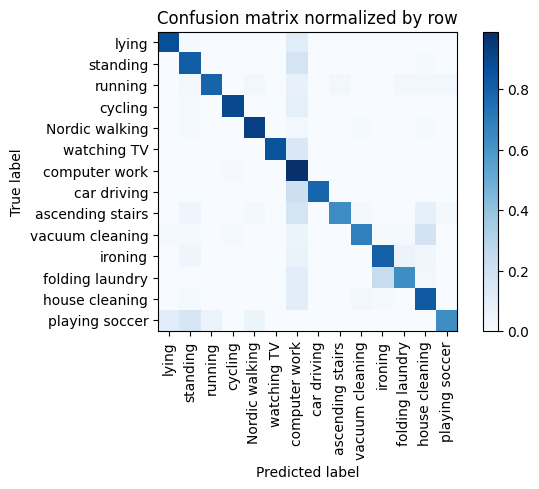

Training Epoch:  80%|████████  | 8/10 [00:22<00:05,  2.95s/it]

Overall accuracy: 0.827



seen: 100%|██████████| 26/26 [00:00<00:00, 77.49batch/s, loss=0.892]


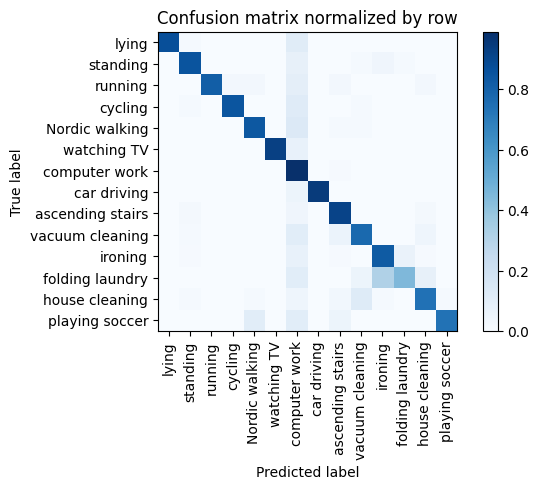

Training Epoch:  90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

Overall accuracy: 0.838



seen: 100%|██████████| 26/26 [00:00<00:00, 86.81batch/s, loss=0.175]


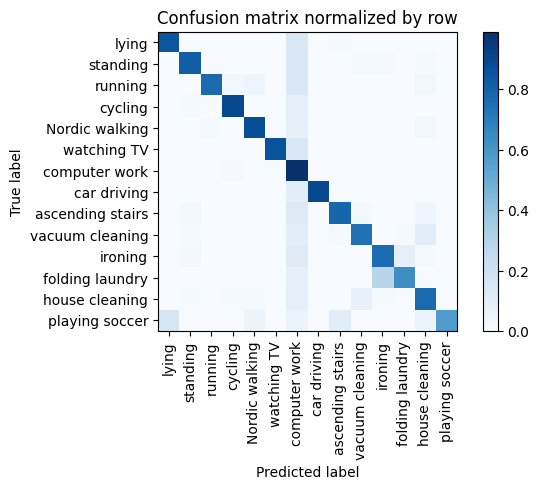

Overall accuracy: 0.824



unseen: 100%|██████████| 28/28 [00:00<00:00, 99.47batch/s, loss=9.83]


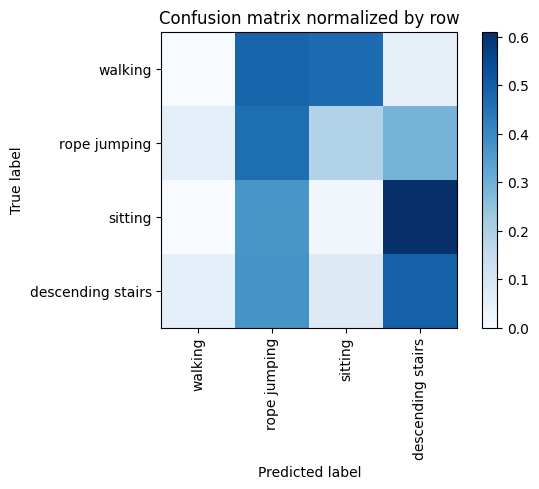

Overall accuracy: 0.129

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.000      0.000      0.000      0.424        370|	 rope jumping: 0.484,	sitting: 0.468,	descending stairs: 0.049,	
          sitting       0.029      0.021      0.025      0.323        282|	 descending stairs: 0.610,	rope jumping: 0.369,	
descending stairs       0.263      0.493      0.343      0.174        152|	 rope jumping: 0.375,	sitting: 0.079,	
     rope jumping       0.086      0.464      0.145      0.079         69|	 descending stairs: 0.290,	sitting: 0.188,	

----------------------------------------------------------------------------------------------------
      avg / total       0.062      0.129      0.079        1.0        873|	      

{'total_accuracy': 0.12943871706758306, 'precision': 0.09464779120476713, 'recall': 0.2446164410795722, 'f1': 0.12826637562389986}
================ Fold-2 ================
Unseen Classes : ['playing s

seen: 100%|██████████| 24/24 [00:00<00:00, 74.61batch/s, loss=0.6]


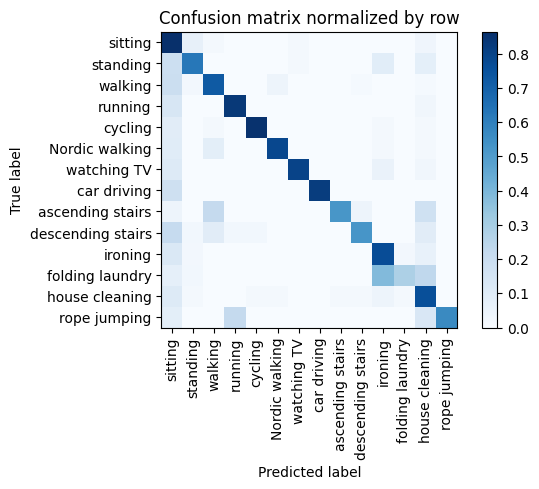

Training Epoch:  10%|█         | 1/10 [00:02<00:23,  2.65s/it]

Overall accuracy: 0.712



seen: 100%|██████████| 24/24 [00:00<00:00, 81.16batch/s, loss=0.548]


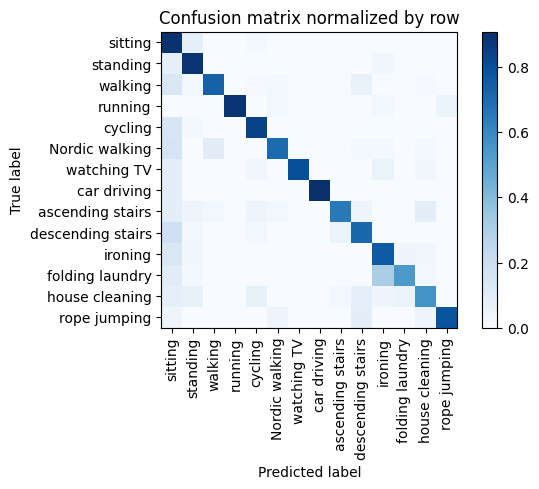

Training Epoch:  20%|██        | 2/10 [00:05<00:20,  2.60s/it]

Overall accuracy: 0.753



seen: 100%|██████████| 24/24 [00:00<00:00, 82.33batch/s, loss=1.14]


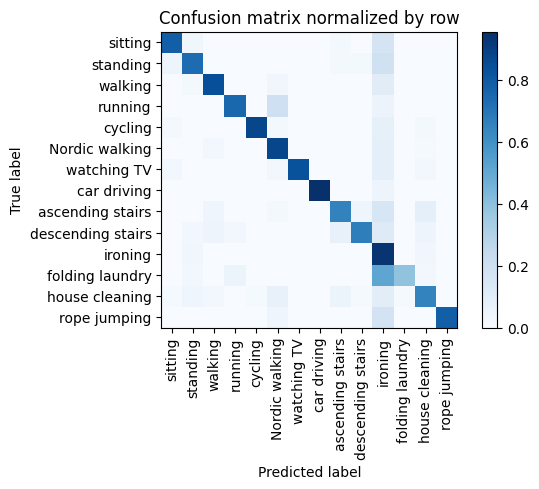

Training Epoch:  30%|███       | 3/10 [00:07<00:17,  2.57s/it]

Overall accuracy: 0.778



seen: 100%|██████████| 24/24 [00:00<00:00, 76.91batch/s, loss=0.358]


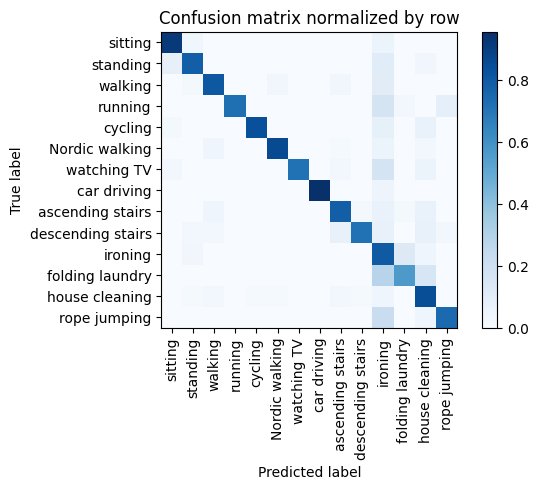

Training Epoch:  40%|████      | 4/10 [00:10<00:15,  2.57s/it]

Overall accuracy: 0.798



seen: 100%|██████████| 24/24 [00:00<00:00, 73.85batch/s, loss=0.706]


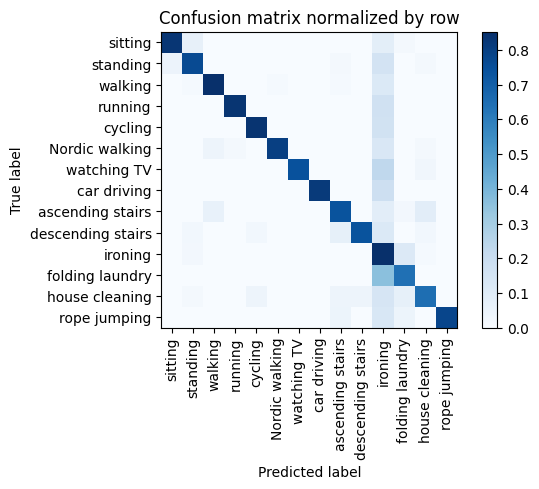

Training Epoch:  50%|█████     | 5/10 [00:13<00:13,  2.62s/it]

Overall accuracy: 0.785



seen: 100%|██████████| 24/24 [00:00<00:00, 78.68batch/s, loss=0.238]


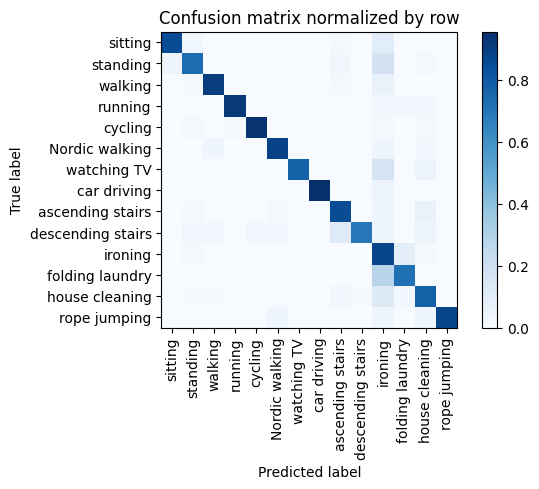

Training Epoch:  60%|██████    | 6/10 [00:15<00:10,  2.66s/it]

Overall accuracy: 0.840



seen: 100%|██████████| 24/24 [00:00<00:00, 78.95batch/s, loss=0.549]


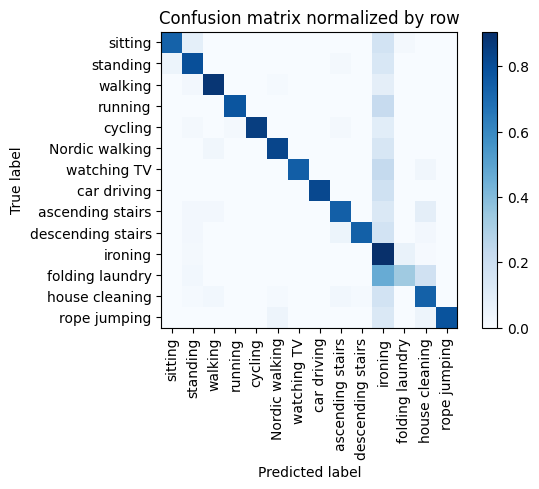

Training Epoch:  70%|███████   | 7/10 [00:18<00:07,  2.65s/it]

Overall accuracy: 0.784



seen: 100%|██████████| 24/24 [00:00<00:00, 69.56batch/s, loss=0.443]


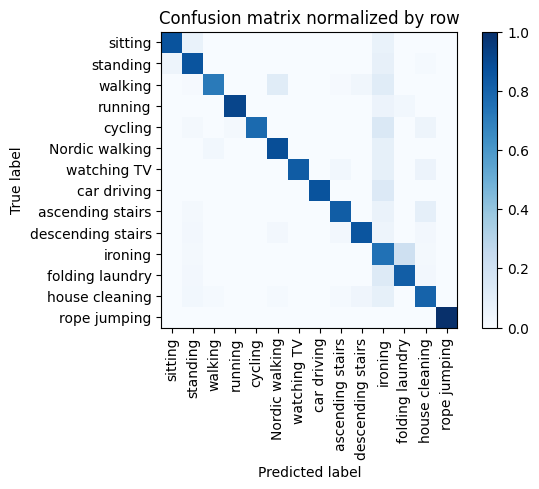

Training Epoch:  80%|████████  | 8/10 [00:21<00:05,  2.68s/it]

Overall accuracy: 0.819



seen: 100%|██████████| 24/24 [00:00<00:00, 74.93batch/s, loss=0.564]


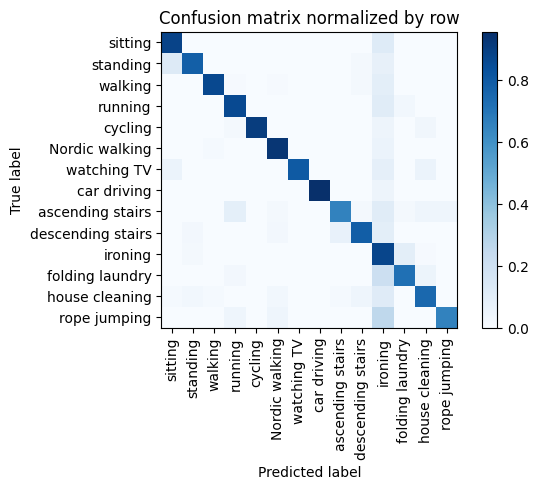

Training Epoch:  90%|█████████ | 9/10 [00:23<00:02,  2.66s/it]

Overall accuracy: 0.826



seen: 100%|██████████| 24/24 [00:00<00:00, 77.66batch/s, loss=0.741]


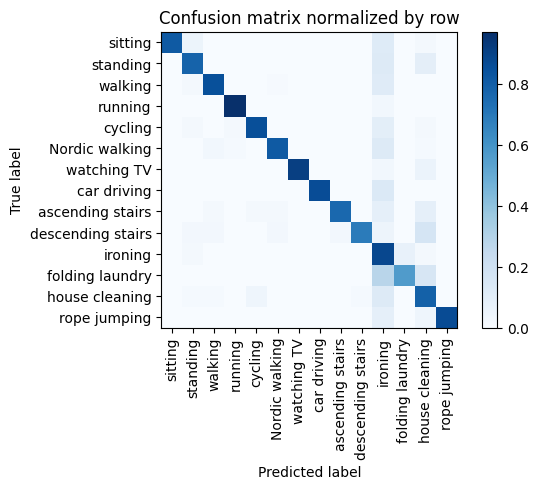

Overall accuracy: 0.818



unseen: 100%|██████████| 35/35 [00:00<00:00, 86.00batch/s, loss=10.5]


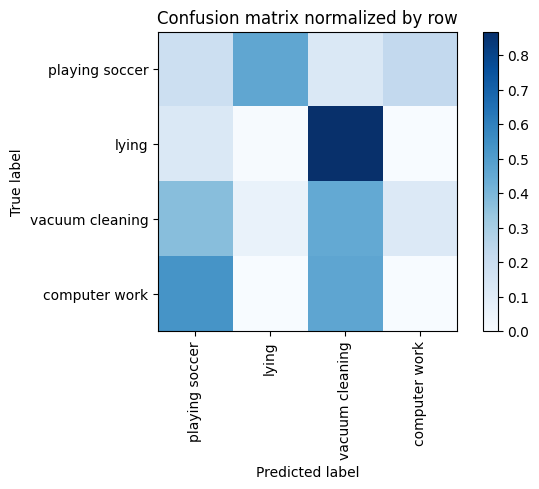

Overall accuracy: 0.125

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.020      0.002      0.004      0.419        463|	 playing soccer: 0.531,	vacuum cleaning: 0.467,	
          lying       0.036      0.007      0.011      0.268        296|	 vacuum cleaning: 0.868,	playing soccer: 0.125,	
vacuum cleaning       0.199      0.451      0.276      0.241        266|	 playing soccer: 0.372,	computer work: 0.117,	
 playing soccer       0.038      0.188      0.063      0.072         80|	 lying: 0.463,	computer work: 0.225,	

----------------------------------------------------------------------------------------------------
    avg / total       0.069      0.125      0.076        1.0       1105|	      

{'total_accuracy': 0.1248868778280543, 'precision': 0.07328799670071899, 'recall': 0.16188610087986297, 'f1': 0.0885918113301116}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic walking

seen: 100%|██████████| 27/27 [00:00<00:00, 76.13batch/s, loss=0.73]


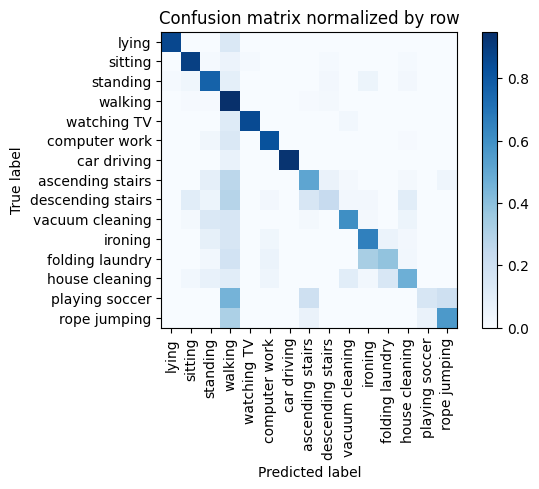

Training Epoch:  10%|█         | 1/10 [00:03<00:28,  3.14s/it]

Overall accuracy: 0.702



seen: 100%|██████████| 27/27 [00:00<00:00, 81.32batch/s, loss=0.639]


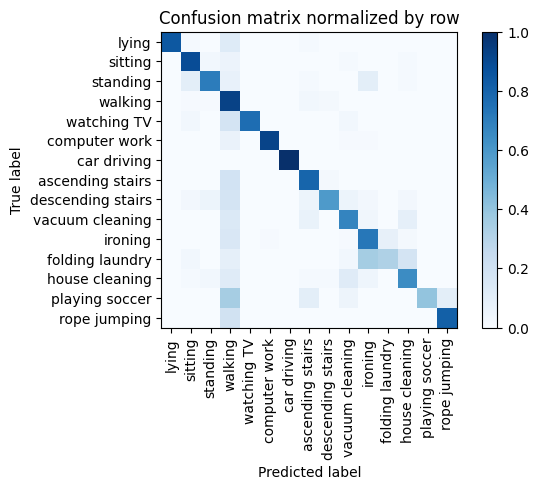

Training Epoch:  20%|██        | 2/10 [00:06<00:24,  3.02s/it]

Overall accuracy: 0.771



seen: 100%|██████████| 27/27 [00:00<00:00, 72.97batch/s, loss=0.488]


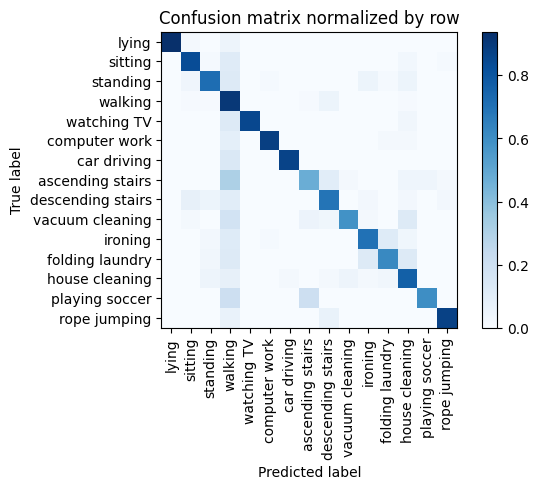

Training Epoch:  30%|███       | 3/10 [00:09<00:20,  2.99s/it]

Overall accuracy: 0.772



seen: 100%|██████████| 27/27 [00:00<00:00, 76.69batch/s, loss=0.68]


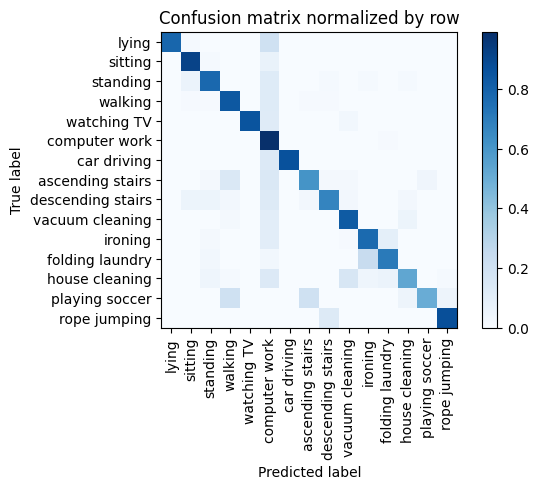

Training Epoch:  40%|████      | 4/10 [00:11<00:17,  2.94s/it]

Overall accuracy: 0.794



seen: 100%|██████████| 27/27 [00:00<00:00, 78.72batch/s, loss=0.866]


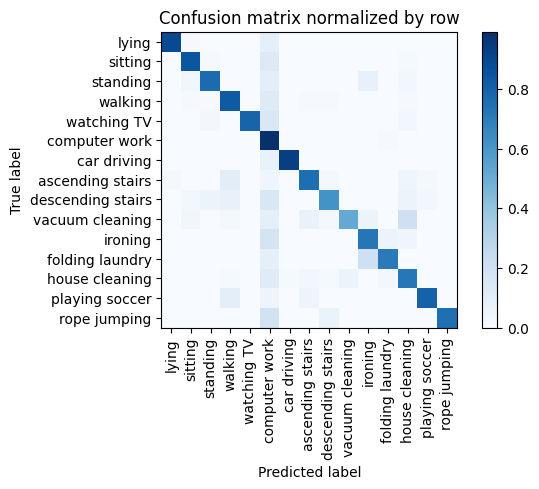

Training Epoch:  50%|█████     | 5/10 [00:14<00:14,  2.95s/it]

Overall accuracy: 0.793



seen: 100%|██████████| 27/27 [00:00<00:00, 71.24batch/s, loss=0.448]


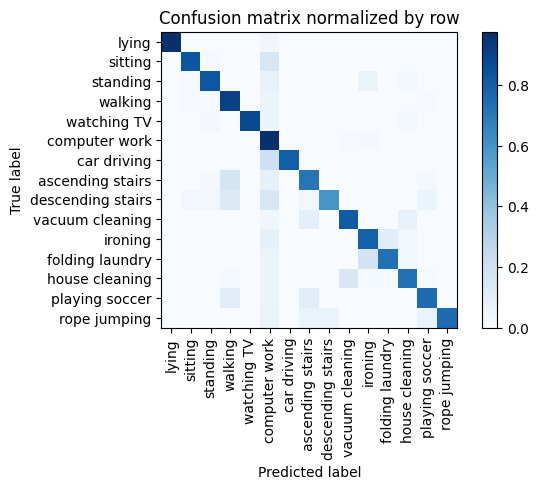

Training Epoch:  60%|██████    | 6/10 [00:17<00:11,  2.98s/it]

Overall accuracy: 0.835



seen: 100%|██████████| 27/27 [00:00<00:00, 76.91batch/s, loss=0.292]


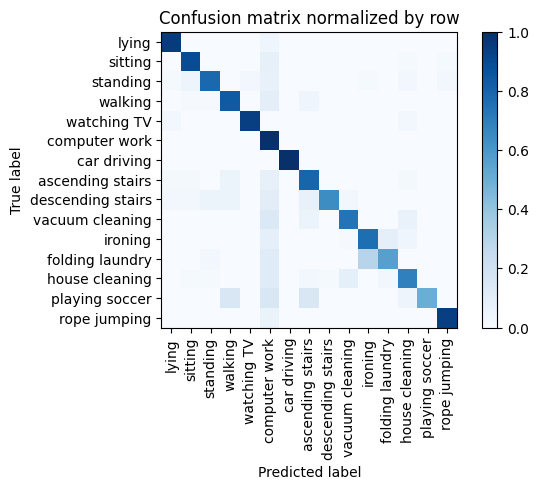

Training Epoch:  70%|███████   | 7/10 [00:20<00:08,  2.96s/it]

Overall accuracy: 0.822



seen: 100%|██████████| 27/27 [00:00<00:00, 69.29batch/s, loss=0.96]


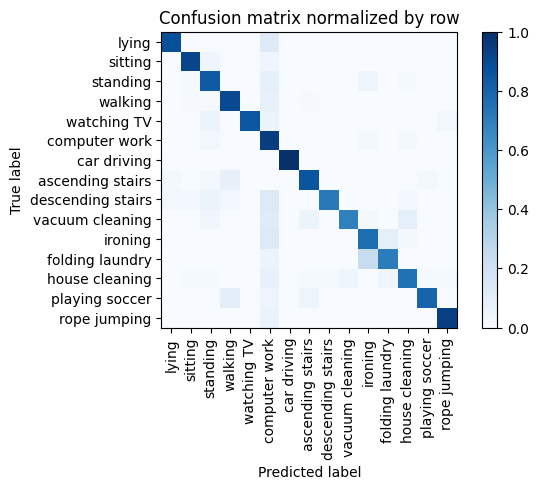

Training Epoch:  80%|████████  | 8/10 [00:23<00:05,  2.95s/it]

Overall accuracy: 0.840



seen: 100%|██████████| 27/27 [00:00<00:00, 78.13batch/s, loss=0.209]


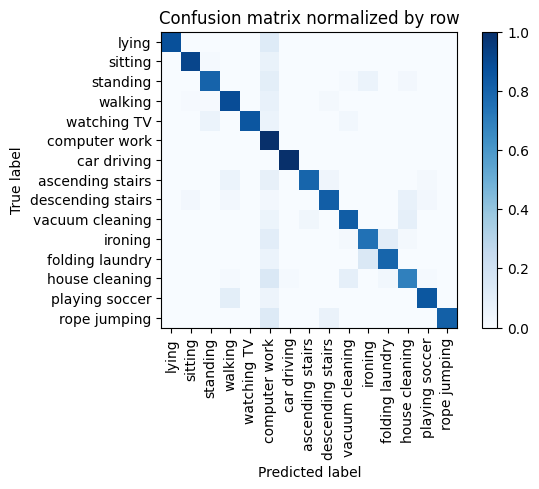

Training Epoch:  90%|█████████ | 9/10 [00:26<00:02,  2.97s/it]

Overall accuracy: 0.851



seen: 100%|██████████| 27/27 [00:00<00:00, 75.94batch/s, loss=0.703]


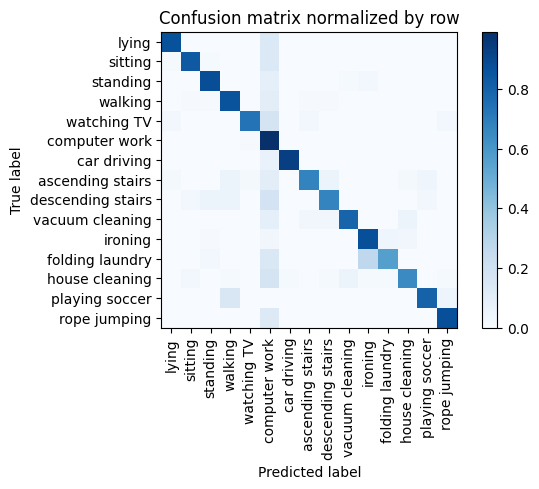

Overall accuracy: 0.823



unseen: 100%|██████████| 22/22 [00:00<00:00, 81.62batch/s, loss=14.5]


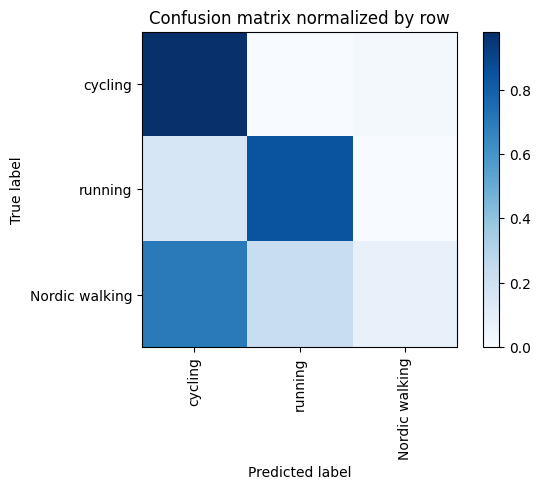

Overall accuracy: 0.575

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.800      0.071      0.130      0.413        283|	 cycling: 0.700,	running: 0.230,	
       cycling       0.530      0.980      0.688      0.371        254|	 Nordic walking: 0.020,	running: 0.000,	
       running       0.658      0.845      0.740      0.216        148|	 cycling: 0.155,	Nordic walking: 0.000,	

----------------------------------------------------------------------------------------------------
   avg / total       0.669      0.575      0.469        1.0        685|	      

{'total_accuracy': 0.5751824817518248, 'precision': 0.6625606569615529, 'recall': 0.6318603111054629, 'f1': 0.5191201347172448}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']


seen: 100%|██████████| 28/28 [00:00<00:00, 78.95batch/s, loss=0.653]


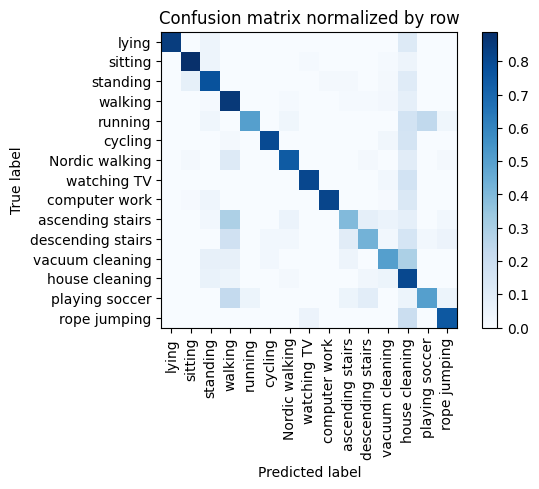

Training Epoch:  10%|█         | 1/10 [00:03<00:27,  3.08s/it]

Overall accuracy: 0.734



seen: 100%|██████████| 28/28 [00:00<00:00, 80.57batch/s, loss=0.604]


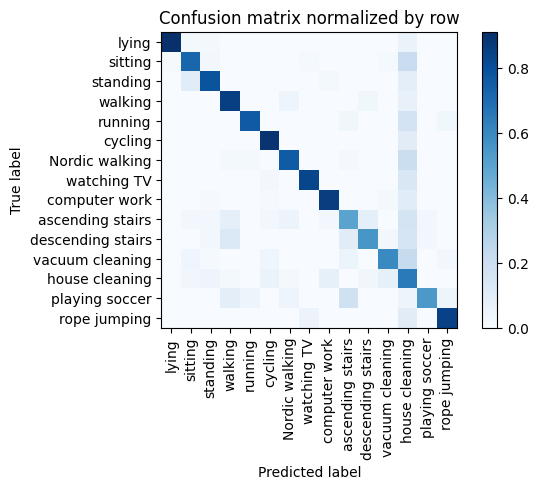

Training Epoch:  20%|██        | 2/10 [00:05<00:23,  2.95s/it]

Overall accuracy: 0.764



seen: 100%|██████████| 28/28 [00:00<00:00, 78.52batch/s, loss=0.682]


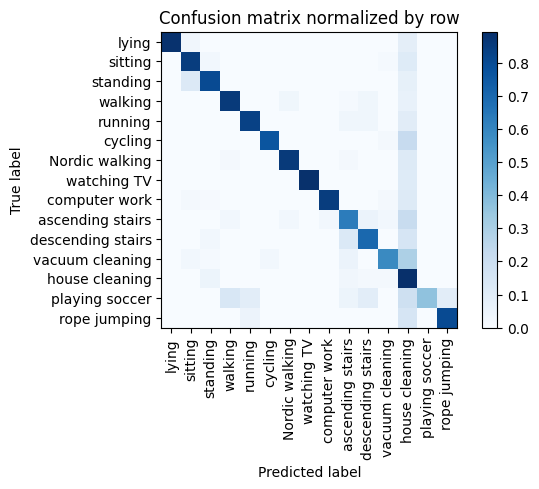

Training Epoch:  30%|███       | 3/10 [00:08<00:20,  2.94s/it]

Overall accuracy: 0.797



seen: 100%|██████████| 28/28 [00:00<00:00, 84.59batch/s, loss=0.411]


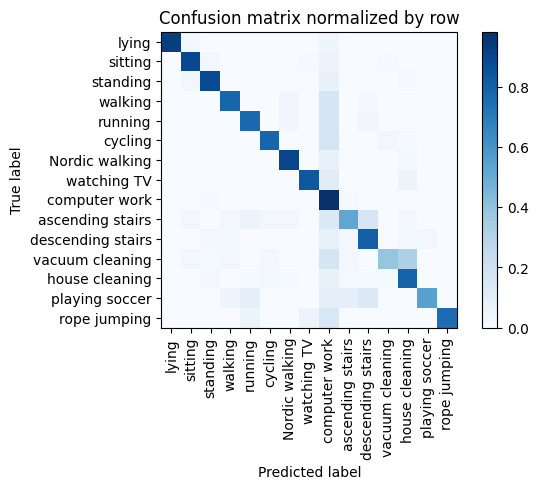

Training Epoch:  40%|████      | 4/10 [00:11<00:17,  2.91s/it]

Overall accuracy: 0.800



seen: 100%|██████████| 28/28 [00:00<00:00, 76.50batch/s, loss=0.755]


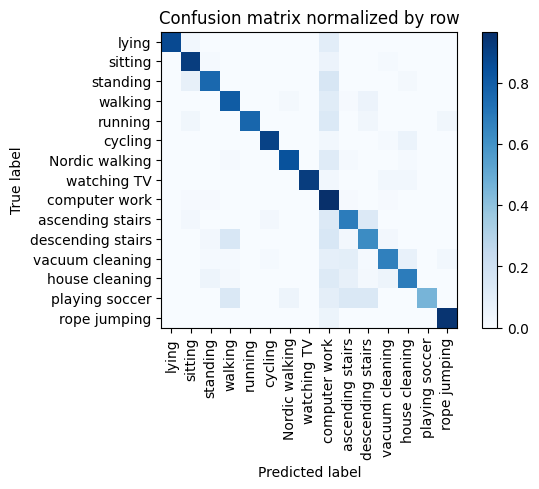

Training Epoch:  50%|█████     | 5/10 [00:14<00:14,  2.94s/it]

Overall accuracy: 0.812



seen: 100%|██████████| 28/28 [00:00<00:00, 80.29batch/s, loss=0.771]


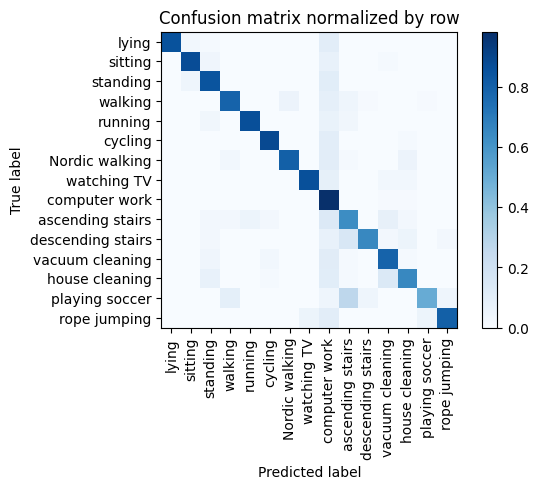

Training Epoch:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

Overall accuracy: 0.817



seen: 100%|██████████| 28/28 [00:00<00:00, 79.32batch/s, loss=0.377]


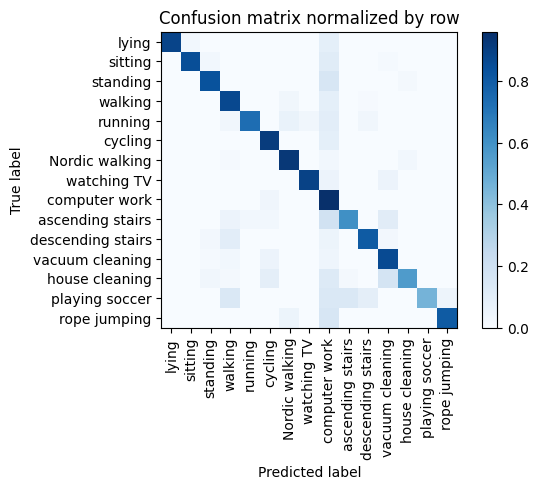

Training Epoch:  70%|███████   | 7/10 [00:20<00:08,  2.95s/it]

Overall accuracy: 0.833



seen: 100%|██████████| 28/28 [00:00<00:00, 82.34batch/s, loss=0.422]


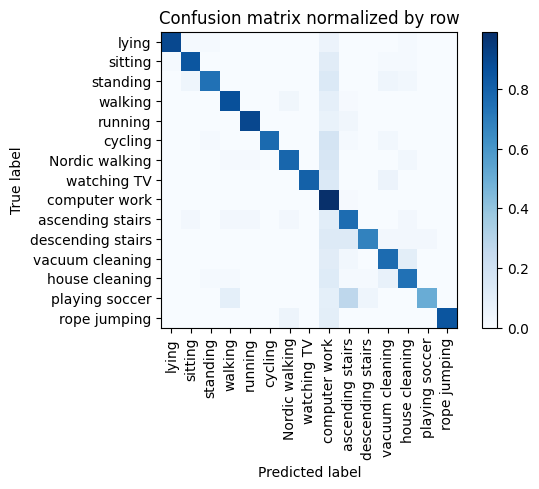

Training Epoch:  80%|████████  | 8/10 [00:23<00:05,  2.92s/it]

Overall accuracy: 0.820



seen: 100%|██████████| 28/28 [00:00<00:00, 76.29batch/s, loss=0.309]


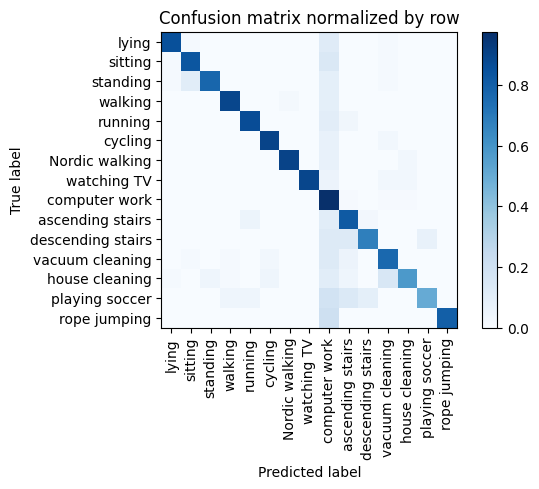

Training Epoch:  90%|█████████ | 9/10 [00:26<00:02,  2.95s/it]

Overall accuracy: 0.828



seen: 100%|██████████| 28/28 [00:00<00:00, 76.09batch/s, loss=0.843]


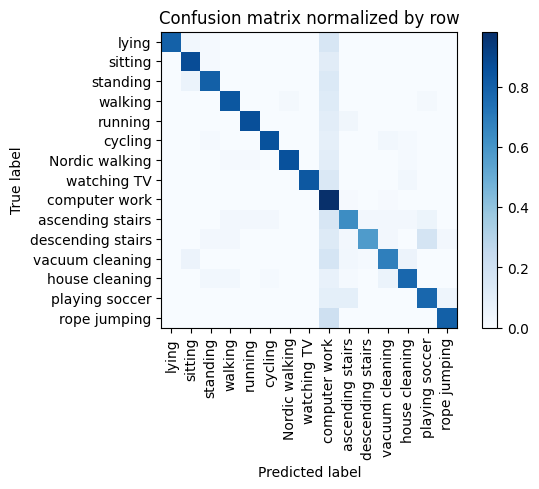

Overall accuracy: 0.818



unseen: 100%|██████████| 19/19 [00:00<00:00, 61.38batch/s, loss=6.74]


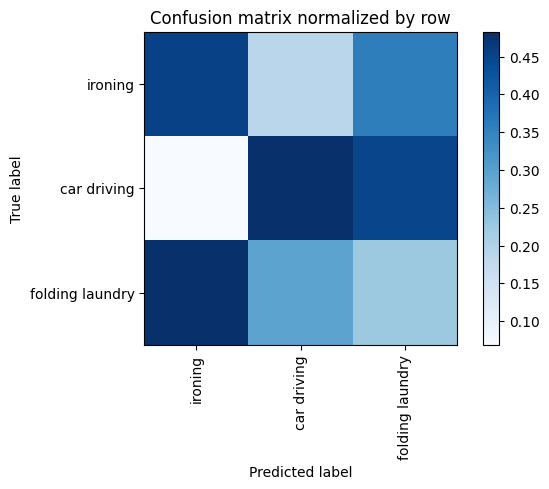

Overall accuracy: 0.397

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.658      0.455      0.538      0.588        352|	 folding laundry: 0.358,	car driving: 0.188,	
folding laundry       0.179      0.225      0.199      0.267        160|	 ironing: 0.481,	car driving: 0.294,	
    car driving       0.271      0.483      0.347      0.145         87|	 folding laundry: 0.448,	ironing: 0.069,	

----------------------------------------------------------------------------------------------------
    avg / total       0.474      0.397      0.420        1.0        599|	      

{'total_accuracy': 0.3973288814691152, 'precision': 0.3695028111797312, 'recall': 0.3874346917450366, 'f1': 0.3614561824821502}
============== Overall Unseen Classes Performance ==============


total_accuracy    0.280756
precision         0.277920
recall            0.315607
f1                0.248339
dtype: float64

In [45]:
from tkinter import N


fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, resampling=True, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=1, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    # print("seen classes > ", seen_classes)
    # print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    # print(seen_classes)
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    
    # build model
    model = Model6a(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], ft_size=feat_size, max_len=seq_len, n_classes=len(seen_classes))
    # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_module = {'feature': nn.CrossEntropyLoss(), 'attribute': AttributeLoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step1(model, train_dl, optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', )
        eval_metrics = eval_step1(model, eval_dl, loss_module, device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.target_feat, phase='seen',  print_report=False)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    if best_acc == 0.0:
        best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step1(model, test_dl, loss_module, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='unseen')
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)
print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
    